In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt

import sys
sys.path.append("..")

from tiny_xgboost import TinyXGBRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

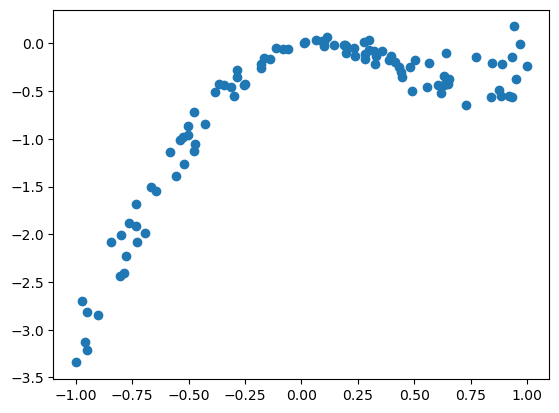

In [2]:
def gw_data(n=100):
    x = np.random.uniform(-1,1,n)
    
    y = 0.5*x - 3*np.power(x,2) + np.power(x,3) + 1.5*np.power(x,4) + np.random.uniform(-0.5,0.5,n)*np.sin(x)
    
    return x.reshape(-1,1), y

x,y=gw_data(100)

plt.figure()
plt.scatter(x.flatten(), y)
plt.show()

In [3]:
def get_gradient(ys, mus, gammas):
    
    assert len(ys) == len(mus)
    assert len(ys) == len(gammas)
    
    Sigmas = np.exp(-2*gammas)
    deltas = mus - ys
    
    gradient = np.array([np.dot(Sigmas, deltas), len(ys) - np.dot(Sigmas, np.power(deltas, 2))])
    
    return gradient


def get_hessian(ys, mus, gammas, add_reg=True, reg_lambda=None):
    
    assert len(ys) == len(mus)
    assert len(ys) == len(gammas)
    
    Sigmas = np.exp(-2*gammas)
    deltas = mus - ys
    
    hessian = np.array([
        [np.sum(Sigmas), -2*np.dot(Sigmas, deltas)],
        [-2*np.dot(Sigmas, deltas), 2*np.dot(Sigmas, np.power(deltas, 2))]
    ])
    
    if add_reg:
        assert reg_lambda is not None
        
        hessian[0,0] += reg_lambda
        hessian[1,1] += reg_lambda
    
    return hessian

def get_inverse_hessian(ys, mus, gammas, add_reg=True, reg_lambda=1):
    
    hessian = get_hessian(ys, mus, gammas, add_reg=add_reg, reg_lambda=reg_lambda)
    
    return np.linalg.inv(hessian)


def obj_star(ys, mus, gammas, reg_lambda):
    
    gradient = get_gradient(ys, mus, gammas)
    grad_t = np.transpose(gradient)
    inv_hessian = get_inverse_hessian(ys, mus, gammas, add_reg=True, reg_lambda=reg_lambda)
    
    return -0.5 * np.dot(grad_t, np.dot(inv_hessian, gradient))

def w_star(ys, mus, gammas, reg_lambda):
    
    inv_hessian = get_inverse_hessian(ys, mus, gammas, add_reg=True, reg_lambda=reg_lambda)
    gradient = get_gradient(ys, mus, gammas)
    
    return -1* np.dot(inv_hessian, gradient)

def exact_gain(delta_w, ys, mus, gammas, reg_lambda):
    
    assert len(delta_w)==2
    
    new_mus = mus + delta_w[0]
    new_gammas = gammas + delta_w[1]
    
    assert len(new_gammas) == len(gammas)
    assert len(new_mus) == len(mus)
    
    loss = np.sum(new_gammas)
    loss+= 0.5*np.dot(np.exp(-2*new_gammas), np.power(new_mus - ys,2))
    loss += (reg_lambda/2)*(np.sum(np.power(delta_w, 2)))
    
    loss -= np.sum(gammas)
    loss -= 0.5*np.dot(np.exp(-2*gammas), np.power(mus - ys,2))
    
    return loss

def approximate_gain(delta_w, ys, mus, gammas, reg_lambda):
    
    gradient = get_gradient(ys, mus, gammas)
    w_t = np.transpose(delta_w)
    hessian = get_hessian(ys, mus, gammas, add_reg=True, reg_lambda=reg_lambda)
    
    gain = np.dot(gradient, delta_w)
    gain += 0.5*np.dot(w_t, np.dot(hessian, w_t))
    
    return gain
    
    

# The first part of this notebook is the working from which I concluded the problem is saddle points

Possibly not interesting anymore, I compared the Taylor surface to the true cost surface.

For the Taylor Surface, I was finding, essentially no matter how big I made it, that the extremum was at the edge (this is because the place where the gradient is zero isn't an extremum but a saddle point)

I then showed by upping reg_lambda, that the Taylor Surface looks more like the true surface for longer, and we can induce a global minimum 

/tmp/ipykernel_246128/3373258966.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(mu_tester))):


  0%|          | 0/250000 [00:00<?, ?it/s]

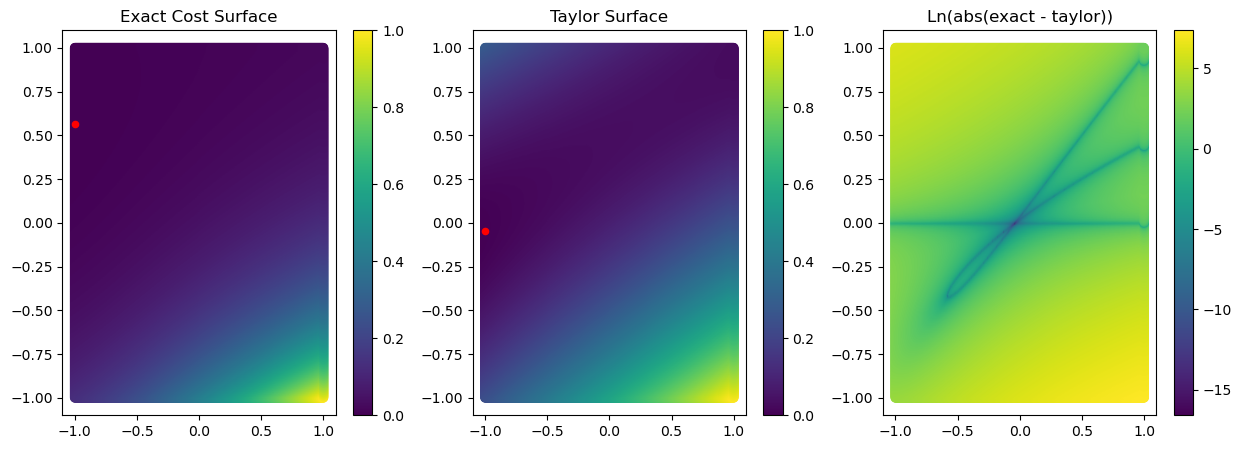

In [4]:
tester = np.linspace(-1,1, 500)

mu_tester = np.repeat(tester, len(tester))
gamma_tester = np.tile(tester, len(tester))

sorter = np.argsort(x.flatten())
split_point = 40 
ys = y[sorter[:split_point]]

mu_train = np.mean(x.flatten())
gamma_train = np.log(np.std(x.flatten()))

mus_so_far = mu_train*np.ones(len(ys), dtype=float)
gammas_so_far = gamma_train*np.ones(len(ys), dtype=float)

obj_left_taylor_surface = []
obj_left_exact = []

for i in tqdm(range(len(mu_tester))):
    
    obj_left_exact.append(exact_gain([mu_tester[i], gamma_tester[i]],
                                     ys,
                                     mus_so_far,
                                     gammas_so_far,
                                     1))
    
    obj_left_taylor_surface.append(approximate_gain([mu_tester[i], gamma_tester[i]],
                                                    ys,
                                                    mus_so_far,
                                                    gammas_so_far,
                                                    1))
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Exact Cost Surface")
plt.scatter(mu_tester, gamma_tester, c=obj_left_exact)
plt.scatter(mu_tester[np.argmin(obj_left_exact)], gamma_tester[np.argmin(obj_left_exact)], c='r', s=20)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Taylor Surface")
plt.scatter(mu_tester, gamma_tester, c=obj_left_taylor_surface)
plt.scatter(mu_tester[np.argmin(obj_left_taylor_surface)], gamma_tester[np.argmin(obj_left_taylor_surface)], c='r', s=20)
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Ln(abs(exact - taylor))")
plt.scatter(mu_tester, gamma_tester, c=np.log(np.abs(np.array(obj_left_taylor_surface) - np.array(obj_left_exact))))
plt.colorbar()
plt.show()


/tmp/ipykernel_130709/606791153.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(mu_tester))):


  0%|          | 0/250000 [00:00<?, ?it/s]

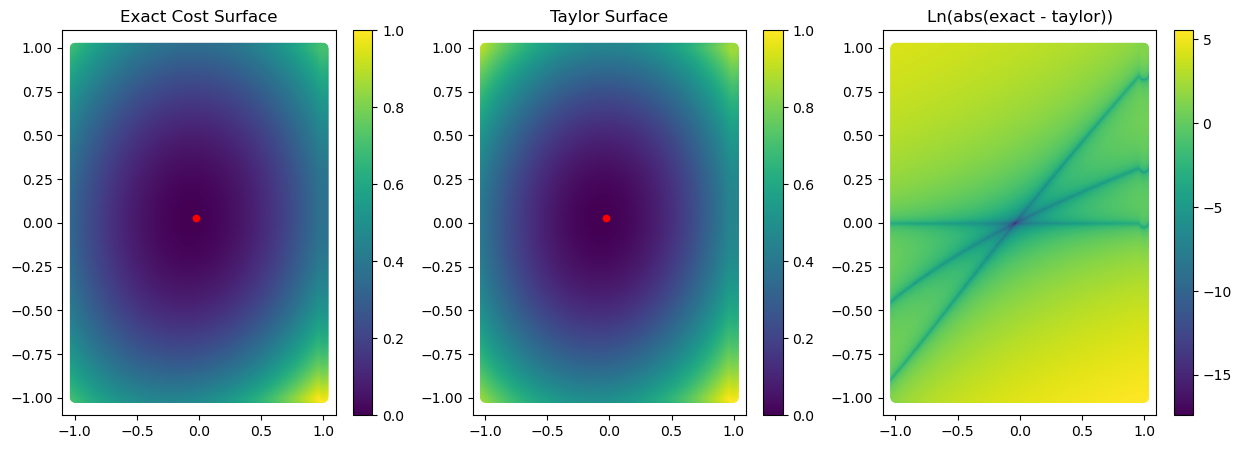

In [218]:
N = 500

tester = np.concatenate((-1*np.logspace(6,-6, 250), np.array([0]), np.logspace(-6,6, 250)), axis=0)

tester = np.linspace(-1,1,N)

REG_LAMBDA = 1_000

mu_tester = np.repeat(tester, len(tester))
gamma_tester = np.tile(tester, len(tester))

sorter = np.argsort(x.flatten())
split_point = 40 
ys = y[sorter[:split_point]]

mus_so_far = 0.5*np.ones(len(ys), dtype=float)
gammas_so_far = 0.5*np.ones(len(ys), dtype=float)

obj_left_taylor_surface = []
obj_left_exact = []

for i in tqdm(range(len(mu_tester))):
    
    obj_left_exact.append(exact_gain([mu_tester[i], gamma_tester[i]],
                                     ys,
                                     mus_so_far,
                                     gammas_so_far,
                                     REG_LAMBDA))
    
    obj_left_taylor_surface.append(approximate_gain([mu_tester[i], gamma_tester[i]],
                                                    ys,
                                                    mus_so_far,
                                                    gammas_so_far,
                                                    REG_LAMBDA))
    

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Exact Cost Surface")
plt.scatter(mu_tester, gamma_tester, c=obj_left_exact)
plt.scatter(mu_tester[np.argmin(obj_left_exact)], gamma_tester[np.argmin(obj_left_exact)], c='r', s=20)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Taylor Surface")
plt.scatter(mu_tester, gamma_tester, c=obj_left_taylor_surface)
plt.scatter(mu_tester[np.argmin(obj_left_taylor_surface)], gamma_tester[np.argmin(obj_left_taylor_surface)], c='r', s=20)
plt.colorbar()
plt.subplot(1,3,3)
plt.title("Ln(abs(exact - taylor))")
plt.scatter(mu_tester, gamma_tester, c=np.log(np.abs(np.array(obj_left_taylor_surface) - np.array(obj_left_exact))))
plt.colorbar()
plt.show()


# By toggling reg_lambda in the above generation cells, we can see the below plot morph from a saddle into a parabaloid 

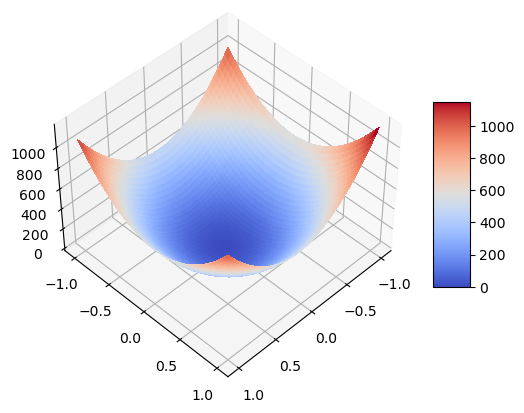

-0.02605210420841686 0.02605210420841675


In [219]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

X, Y = np.meshgrid(tester, tester)

surf = ax.plot_surface(X, Y, np.array(obj_left_taylor_surface).reshape(len(tester),len(tester)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(45, 45)
plt.show()

print(mu_tester[np.argmin(obj_left_taylor_surface)], gamma_tester[np.argmin(obj_left_taylor_surface)])

In [220]:
print("w* of the exact loss surface = ", [mu_tester[np.argmin(obj_left_exact)], gamma_tester[np.argmin(obj_left_exact)]])
print("obj* of the exact loss surface = ", np.min(obj_left_exact))
print("w* of the Taylor loss surface = ", [mu_tester[np.argmin(obj_left_taylor_surface)], gamma_tester[np.argmin(obj_left_taylor_surface)]])
print("obj* of the Taylor loss surface = " , np.min(obj_left_taylor_surface))
#print("Anti obj* of the Taylor loss surface = ", np.max(obj_left_taylor_surface))

print("w* xbg formula = ", w_star(ys, mus_so_far, gammas_so_far, REG_LAMBDA))
print("obj* xgb formula = ", obj_star(ys, mus_so_far, gammas_so_far, REG_LAMBDA))


w_st = w_star(ys, mus_so_far, gammas_so_far, REG_LAMBDA)
print("obj* of the Taylor loss surface evaluated at w* calcluated brute force from the Taylor surface = ", 
     approximate_gain(w_st, ys, mus_so_far, gammas_so_far, REG_LAMBDA))

w* of the exact loss surface =  [-0.02605210420841686, 0.02605210420841675]
obj* of the exact loss surface =  -0.7491792339398984
w* of the Taylor loss surface =  [-0.02605210420841686, 0.02605210420841675]
obj* of the Taylor loss surface =  -0.7471170153217983
w* xbg formula =  [-0.02698351  0.0244859 ]
obj* xgb formula =  -0.7488699992114343
obj* of the Taylor loss surface evaluated at w* calcluated brute force from the Taylor surface =  -0.7488699992114343


# Heteroskedastic Gaussian Benchmarking

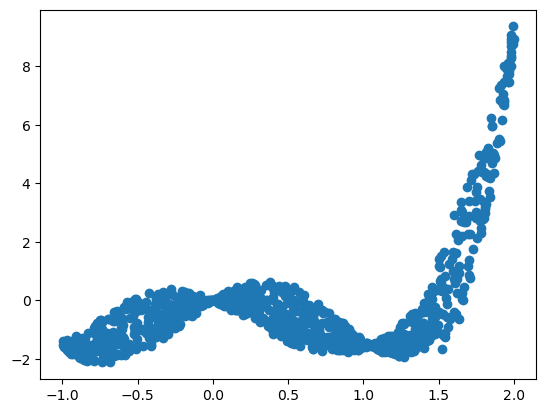

In [340]:
def gw_data(n=100):
    x = np.random.uniform(-1,2,n)
    
    y = 0.5*x - 3*np.power(x,2) - 0.5*np.power(x,3) + 1.5*np.power(x,4) + np.random.uniform(-1,1, n)*np.sin(3*x)*np.where(np.abs(x)>1.5,2,1) - np.where(x<-1.5,3,0)- np.where(x<-1.8,3,0)
    
    return x.reshape(-1,1), y

x,y = gw_data(10_00)

plt.scatter(x.flatten(), y)

# For benchmarking:

## When Sigma is Conditional 

$$L = \sum_{i=1}^{N_{test}}\ln \left[\frac{1}{\sqrt{2\pi \sigma_{i}^{2}}}e^{-\frac{1}{2}\frac{(y_{i}-\mu_{i})^{2}}{\sigma_{i}^{2}}}\right]=\frac{N_{test}}{2}\ln 2\pi -\sum_{i=1}^{N}\left[\ln \sigma_{i} + \frac{1}{2}\frac{(y_{i}-\mu_{i})^{2}}{\sigma_{i}^{2}}\right]$$

## When Sigma is a Constant

$$L =N_{test}\left(\frac{\ln 2\pi}{2}- \ln \sigma\right) -\sum_{i=1}^{N} + \frac{1}{2}\frac{(y_{i}-\mu_{i})^{2}}{\sigma ^{2}}$$

where the factor of $N_{test}\frac{\ln 2\pi}{2}$ is constant to both so can be dropped

Note that we need to find the optimal sigma in the "constant $\sigma$ case". By differentiation L wrt $\sigma$, we find the maximum likelihood estimator is 

$$\hat{\sigma} = \sqrt{\frac{\sum_{i=1}^{N}\left(y_{i}-\mu_{i}\right)^{2}}{N}}$$

where note that this estimator is not calculated on the test set. It's debateable whether we want to calculate it on the train or eval set, however either is valid, whichever gives us a better _test_ cross-entropy

In terms of evaluation, I'll only implement the "when $\sigma$ is conditional" case as this should be able to handle constant sigmas as well

In [95]:
def log_likelihood(y, mu, sigma):
    
    #NOTE that sigma must be vectorlike - currently haven't implemented any quality control here
    
    #also we follow the usual convention and divide this by the size of the test set to make the quantity dataset size invariant 
    return -1*np.mean(np.log(sigma) + 0.5*np.power((y-mu)/sigma, 2))
    

In [80]:
x_test, y_test = gw_data(n=100_000)

In [81]:
x_train, x_eval, y_train, y_eval = train_test_split(x,y, test_size=0.25)

In [107]:
model = TinyXGBRegressor(
    objective="distribution:normal",
    max_depth=1,
    n_estimators=200,
    learning_rate=1.0,
    reg_lambda=100,
    early_stopping_rounds=200
)


model, debug = model.fit(
    x_train, y_train, eval_set=(x_eval, y_eval), debug=True,
)
print("*****")
reg = XGBRegressor(max_depth=1, objective='reg:squarederror', reg_lambda=1, learning_rate=0.1, early_stopping_rounds=5, eval_metric='rmse', n_estimators=1000)

reg.fit(x_train, y_train, eval_set=[(x_eval, y_eval)], verbose=True)

sigma_const = np.sqrt(np.mean(np.power(reg.predict(x_eval)-y_eval, 2)))

print("TXGB RMSE = %.5f"%(np.mean(np.power(model.predict(x_test, iteration_range=(0,50))[:, 0] - y_test,2))))
print("Vanilla XGB = %.5f"%(np.mean(np.power(reg.predict(x_test) - y_test,2))))

print("TXGB Log-Likelihood = ", log_likelihood(y_test, model.predict(x_test, iteration_range=(0,50))[:,0], model.predict(x_test)[:,1]))
print("Vanilla XGB Log-Likelihood = ", log_likelihood(y_test, reg.predict(x_test), sigma_const))



[0]	train-loss=1.74610, val-loss=1.59749
[1]	train-loss=1.73798, val-loss=1.46233
[2]	train-loss=2.32466, val-loss=1.78091
[3]	train-loss=3.74668, val-loss=2.79260
[4]	train-loss=5.98851, val-loss=4.41044
[5]	train-loss=7.67547, val-loss=5.58752
[6]	train-loss=11.04819, val-loss=7.89731
[7]	train-loss=13.47511, val-loss=9.68899
[8]	train-loss=17.70715, val-loss=12.79708
[9]	train-loss=20.57583, val-loss=14.89549
[10]	train-loss=23.60543, val-loss=17.29241
[11]	train-loss=29.25065, val-loss=21.46741
[12]	train-loss=35.08304, val-loss=25.82671
[13]	train-loss=41.04055, val-loss=30.25053
[14]	train-loss=48.51413, val-loss=35.88981
[15]	train-loss=52.22108, val-loss=38.72072
[16]	train-loss=55.24459, val-loss=42.35866
[17]	train-loss=62.96478, val-loss=48.31675
[18]	train-loss=72.88470, val-loss=56.08119
[19]	train-loss=76.88714, val-loss=59.19444
[20]	train-loss=84.73792, val-loss=65.29860
[21]	train-loss=89.86560, val-loss=69.26976
[22]	train-loss=93.51938, val-loss=72.06110
[23]	train-l

[1]	validation_0-rmse:1.13494
[2]	validation_0-rmse:1.04351
[3]	validation_0-rmse:0.96176
[4]	validation_0-rmse:0.87835
[5]	validation_0-rmse:0.81611
[6]	validation_0-rmse:0.74908
[7]	validation_0-rmse:0.69864
[8]	validation_0-rmse:0.64512
[9]	validation_0-rmse:0.60438
[10]	validation_0-rmse:0.56244
[11]	validation_0-rmse:0.52383
[12]	validation_0-rmse:0.48982
[13]	validation_0-rmse:0.45999
[14]	validation_0-rmse:0.43344
[15]	validation_0-rmse:0.40981
[16]	validation_0-rmse:0.39034
[17]	validation_0-rmse:0.37104
[18]	validation_0-rmse:0.35347
[19]	validation_0-rmse:0.33660
[20]	validation_0-rmse:0.32250
[21]	validation_0-rmse:0.30995
[22]	validation_0-rmse:0.29848
[23]	validation_0-rmse:0.28758
[24]	validation_0-rmse:0.27823
[25]	validation_0-rmse:0.26984
[26]	validation_0-rmse:0.26221
[27]	validation_0-rmse:0.25587
[28]	validation_0-rmse:0.24971
[29]	validation_0-rmse:0.24432
[30]	validation_0-rmse:0.23928
[31]	validation_0-rmse:0.23535
[32]	validation_0-rmse:0.23124
[33]	validation_0

# Visualise txgb training process 

By toggling reg_lambda from 1->100, we can see the results going from total BS to sensible

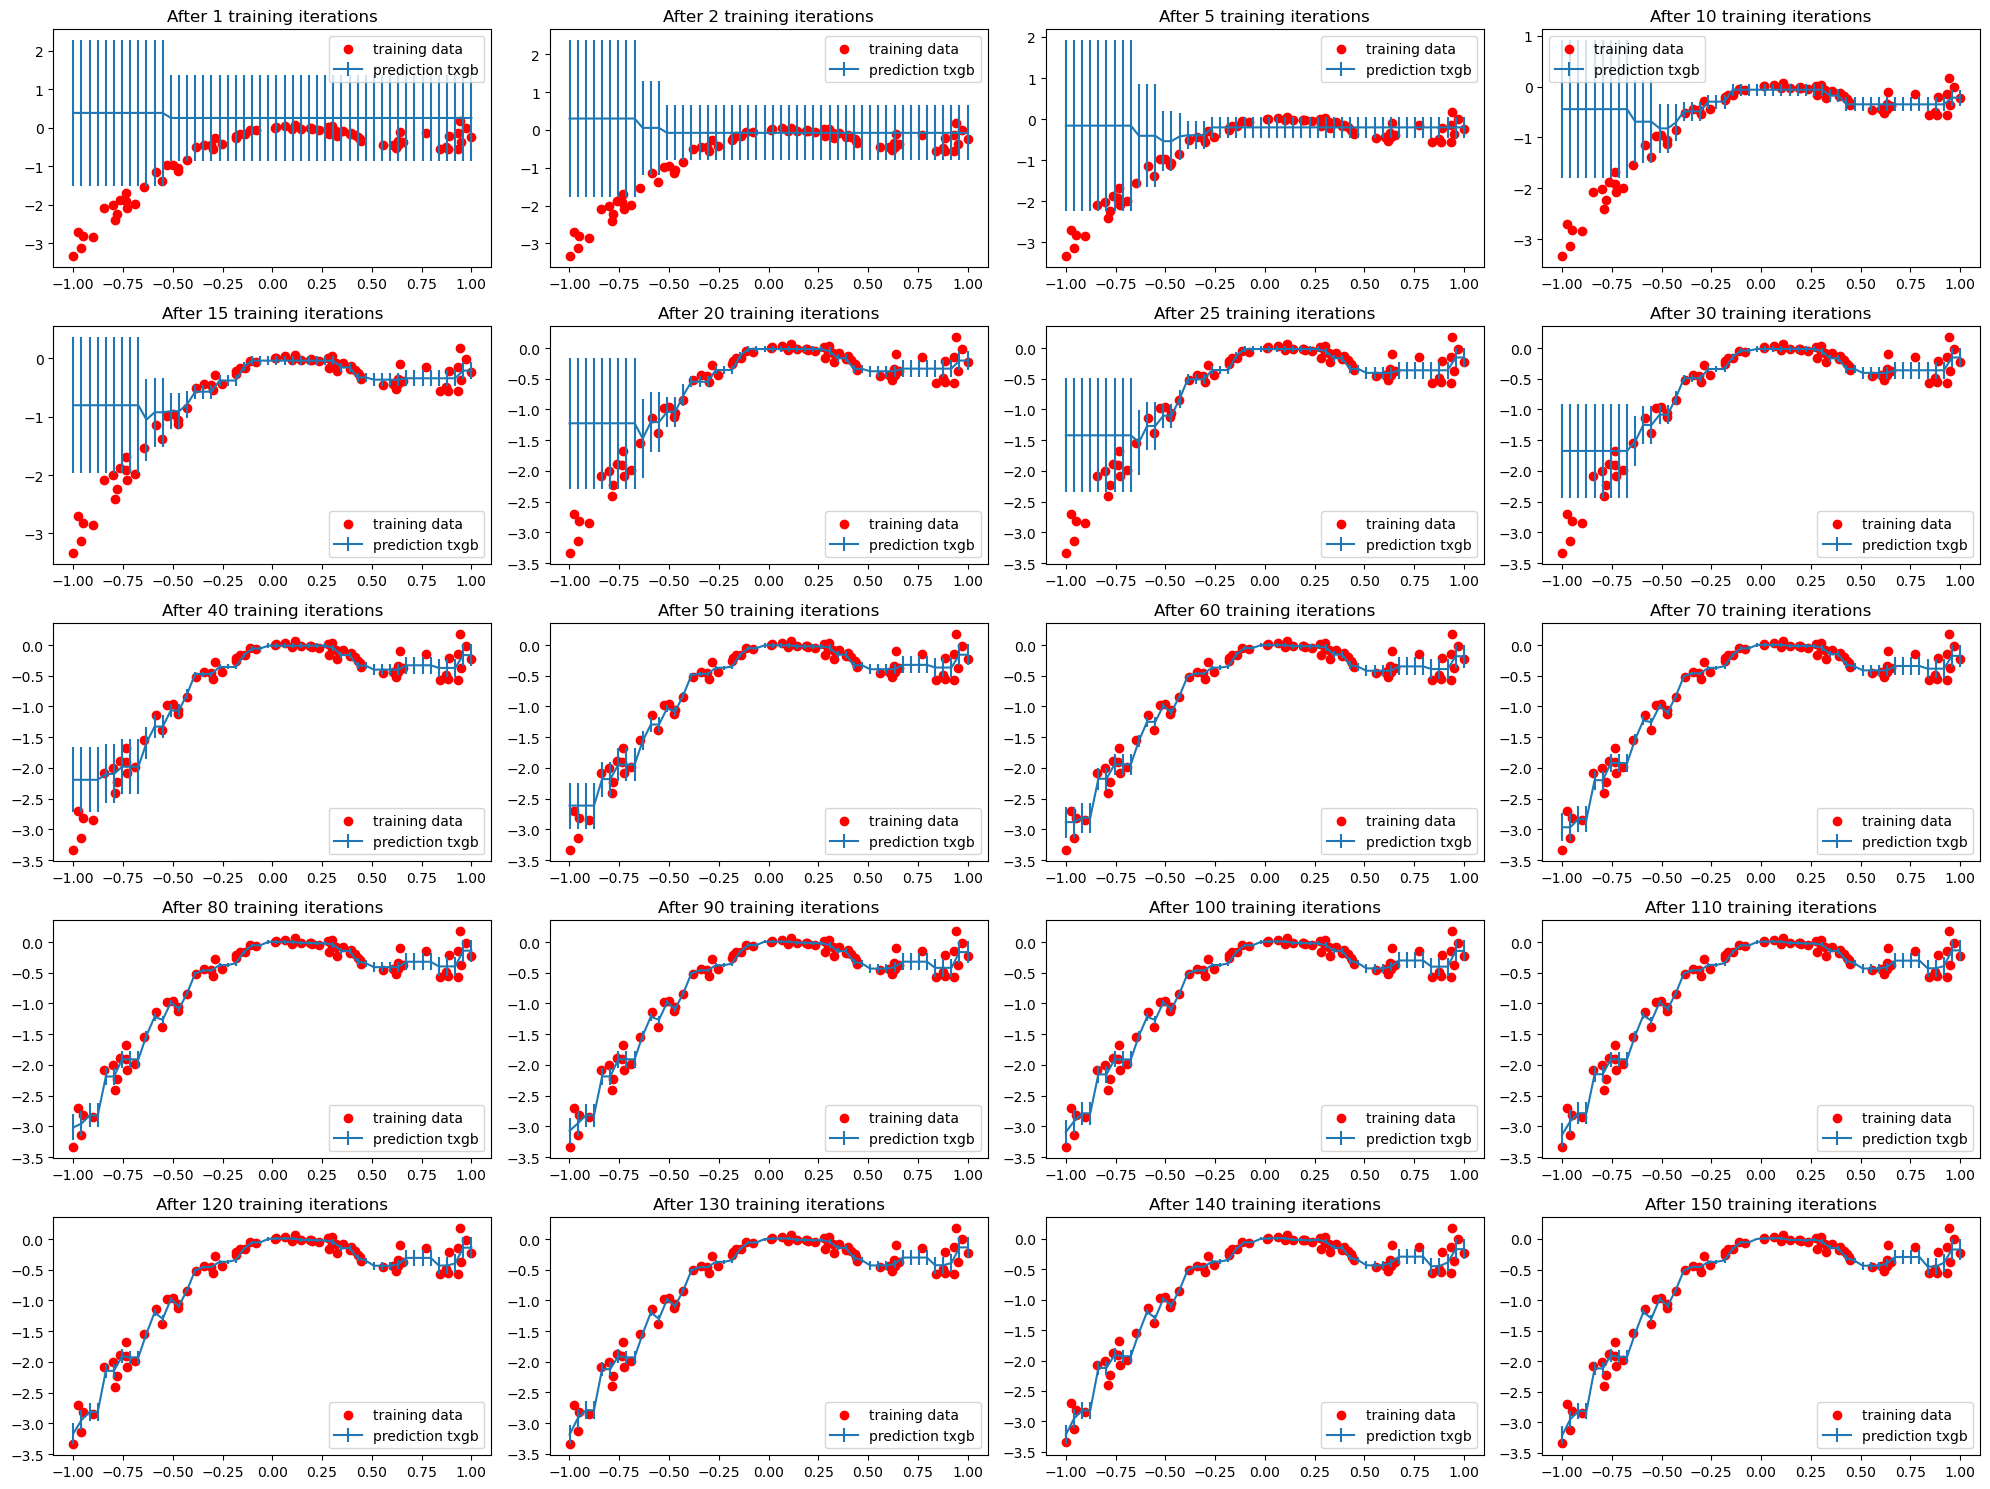

In [115]:
tester = np.linspace(np.min(x_train),np.max(x_train), 50).reshape(-1,1)
counter=1
plt.figure(figsize=(20,15))

for iterations in [1,2,5,10,15,20,25,30,40,50] + list(range(60,160,10)):
    
    preds = model.predict(tester, iteration_range=(0,iterations))
    
    plt.subplot(5,4,counter)
    plt.title("After %d training iterations"%iterations)
    plt.errorbar(tester, preds[:,0], yerr=preds[:, 1], label='prediction txgb')
    plt.scatter(x_train.flatten(), y_train, c='r', label='training data')
    plt.legend()
    plt.tight_layout()
    counter+=1
plt.show()

# By tracking the manually implemented x-entropy/log-likelihood, we can see the pattern we're expecting

This however is not mirrored by the output when we train txgb. Accordingly, it's necessary to set `early_stopping_rounds` to a high number (ideally=`num_estimators`) in order to not get it to instantly exit

/tmp/ipykernel_246128/4013450561.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iterations in tqdm(range(1,200)):


  0%|          | 0/199 [00:00<?, ?it/s]

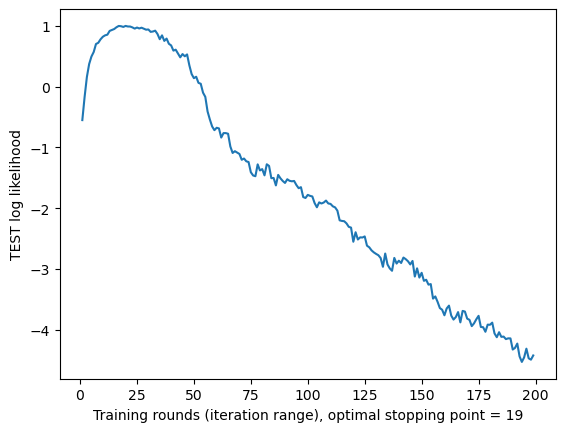

Optimal Test x-ent =  -1.0006243872936902


In [109]:
log_likes = []
for iterations in tqdm(range(1,200)):
    preds = model.predict(x_test, iteration_range=(0, iterations))
    log_likes.append(log_likelihood(y_test, preds[:,0], preds[:,1]))
    
plt.figure()
plt.plot(range(1,200), log_likes)
plt.xlabel("Training rounds (iteration range), optimal stopping point = %d"%np.argmax(log_likes))
plt.ylabel("TEST log likelihood")
plt.show()

print("Optimal Test x-ent = ", -1*np.max(log_likes))

/tmp/ipykernel_246128/274317640.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iterations in tqdm(range(1,200)):


  0%|          | 0/199 [00:00<?, ?it/s]

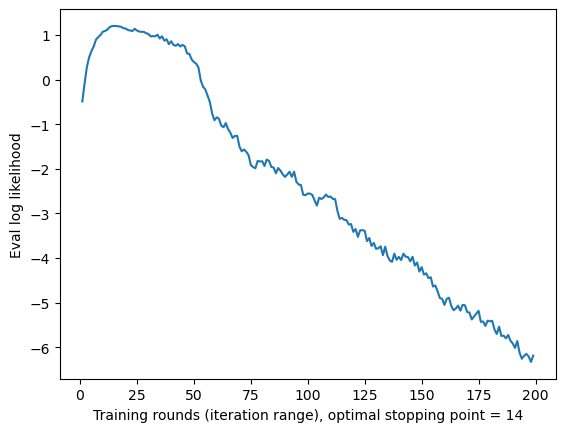

Optimal Eval x-ent =  -1.202423307658907


In [110]:
log_likes = []
for iterations in tqdm(range(1,200)):
    preds = model.predict(x_eval, iteration_range=(0, iterations))
    log_likes.append(log_likelihood(y_eval, preds[:,0], preds[:,1]))
    
plt.figure()
plt.plot(range(1,200), log_likes)
plt.xlabel("Training rounds (iteration range), optimal stopping point = %d"%np.argmax(log_likes))
plt.ylabel("Eval log likelihood")
plt.show()

print("Optimal Eval x-ent = ", -1*np.max(log_likes))

In [114]:
print("xgb Vanilla Test x-cent = ", -1*log_likelihood(y_test, reg.predict(x_test),  np.sqrt(np.mean(np.power(reg.predict(x_eval)-y_eval,2))) ))

xgb Vanilla Test x-cent =  -1.2362279111579546


# Manual XGB (max depth 1)

In some sense, the below might be absolute now, this is a crude but highly-debuggable implementation of hereteroskedastic Gaussian xgb. It is very crude and has the following drawbacks:

* No .predict() method, just gives you the prediction associated with each training point 
* No recursion, only mirrors xgb with `max_depth=1` 
* Obviously not optimised at all, will be slow

In [30]:
def find_best_split(sorted_ys, mus_so_far, gammas_so_far, reg_lambda, learning_rate=1.0):
    
    assert(learning_rate<=1. and learning_rate>0.)
    
    obj = []
    
    for i in range(1, len(sorted_ys)-1):
        ys_left = sorted_ys[:i]
        ys_right = sorted_ys[i:]
        
        obj_left = obj_star(ys_left, mus_so_far[:i], gammas_so_far[:i], reg_lambda)
        obj_right = obj_star(ys_right, mus_so_far[i:], gammas_so_far[i:], reg_lambda)
        
        obj.append(obj_left + obj_right)
        
    optimal_split_point = np.argmin(obj)+1 
    
    #print("optimal split point = ", optimal_split_point)
    
    ys_left = sorted_ys[:optimal_split_point]
    ys_right = sorted_ys[optimal_split_point:]
    
    w_star_left = w_star(ys_left, mus_so_far[:optimal_split_point], gammas_so_far[:optimal_split_point], reg_lambda)
    w_star_right = w_star(ys_right, mus_so_far[optimal_split_point:], gammas_so_far[optimal_split_point:], reg_lambda)
    
    mu_ret = mus_so_far.copy()
    mu_ret[:optimal_split_point] += learning_rate*w_star_left[0]
    mu_ret[optimal_split_point:] += learning_rate*w_star_right[0]
    
    gammas_ret = gammas_so_far.copy()
    gammas_ret[:optimal_split_point] += learning_rate*w_star_left[1]
    gammas_ret[optimal_split_point:] += learning_rate*w_star_right[1]
    
    return mu_ret, gammas_ret
    
    

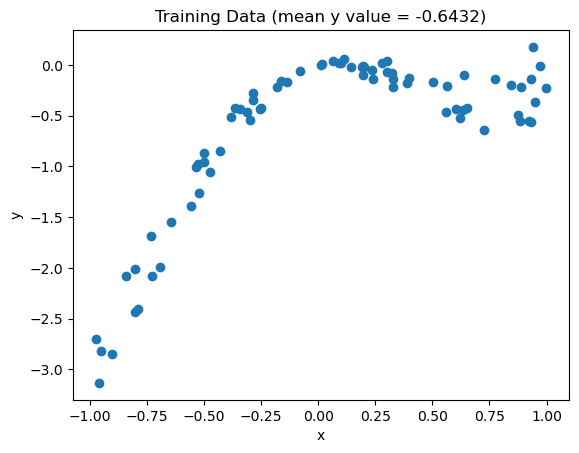

In [20]:
plt.figure()
plt.title("Training Data (mean y value = %.4f)"%np.mean(y_train))
plt.scatter(x_train.flatten(), y_train)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

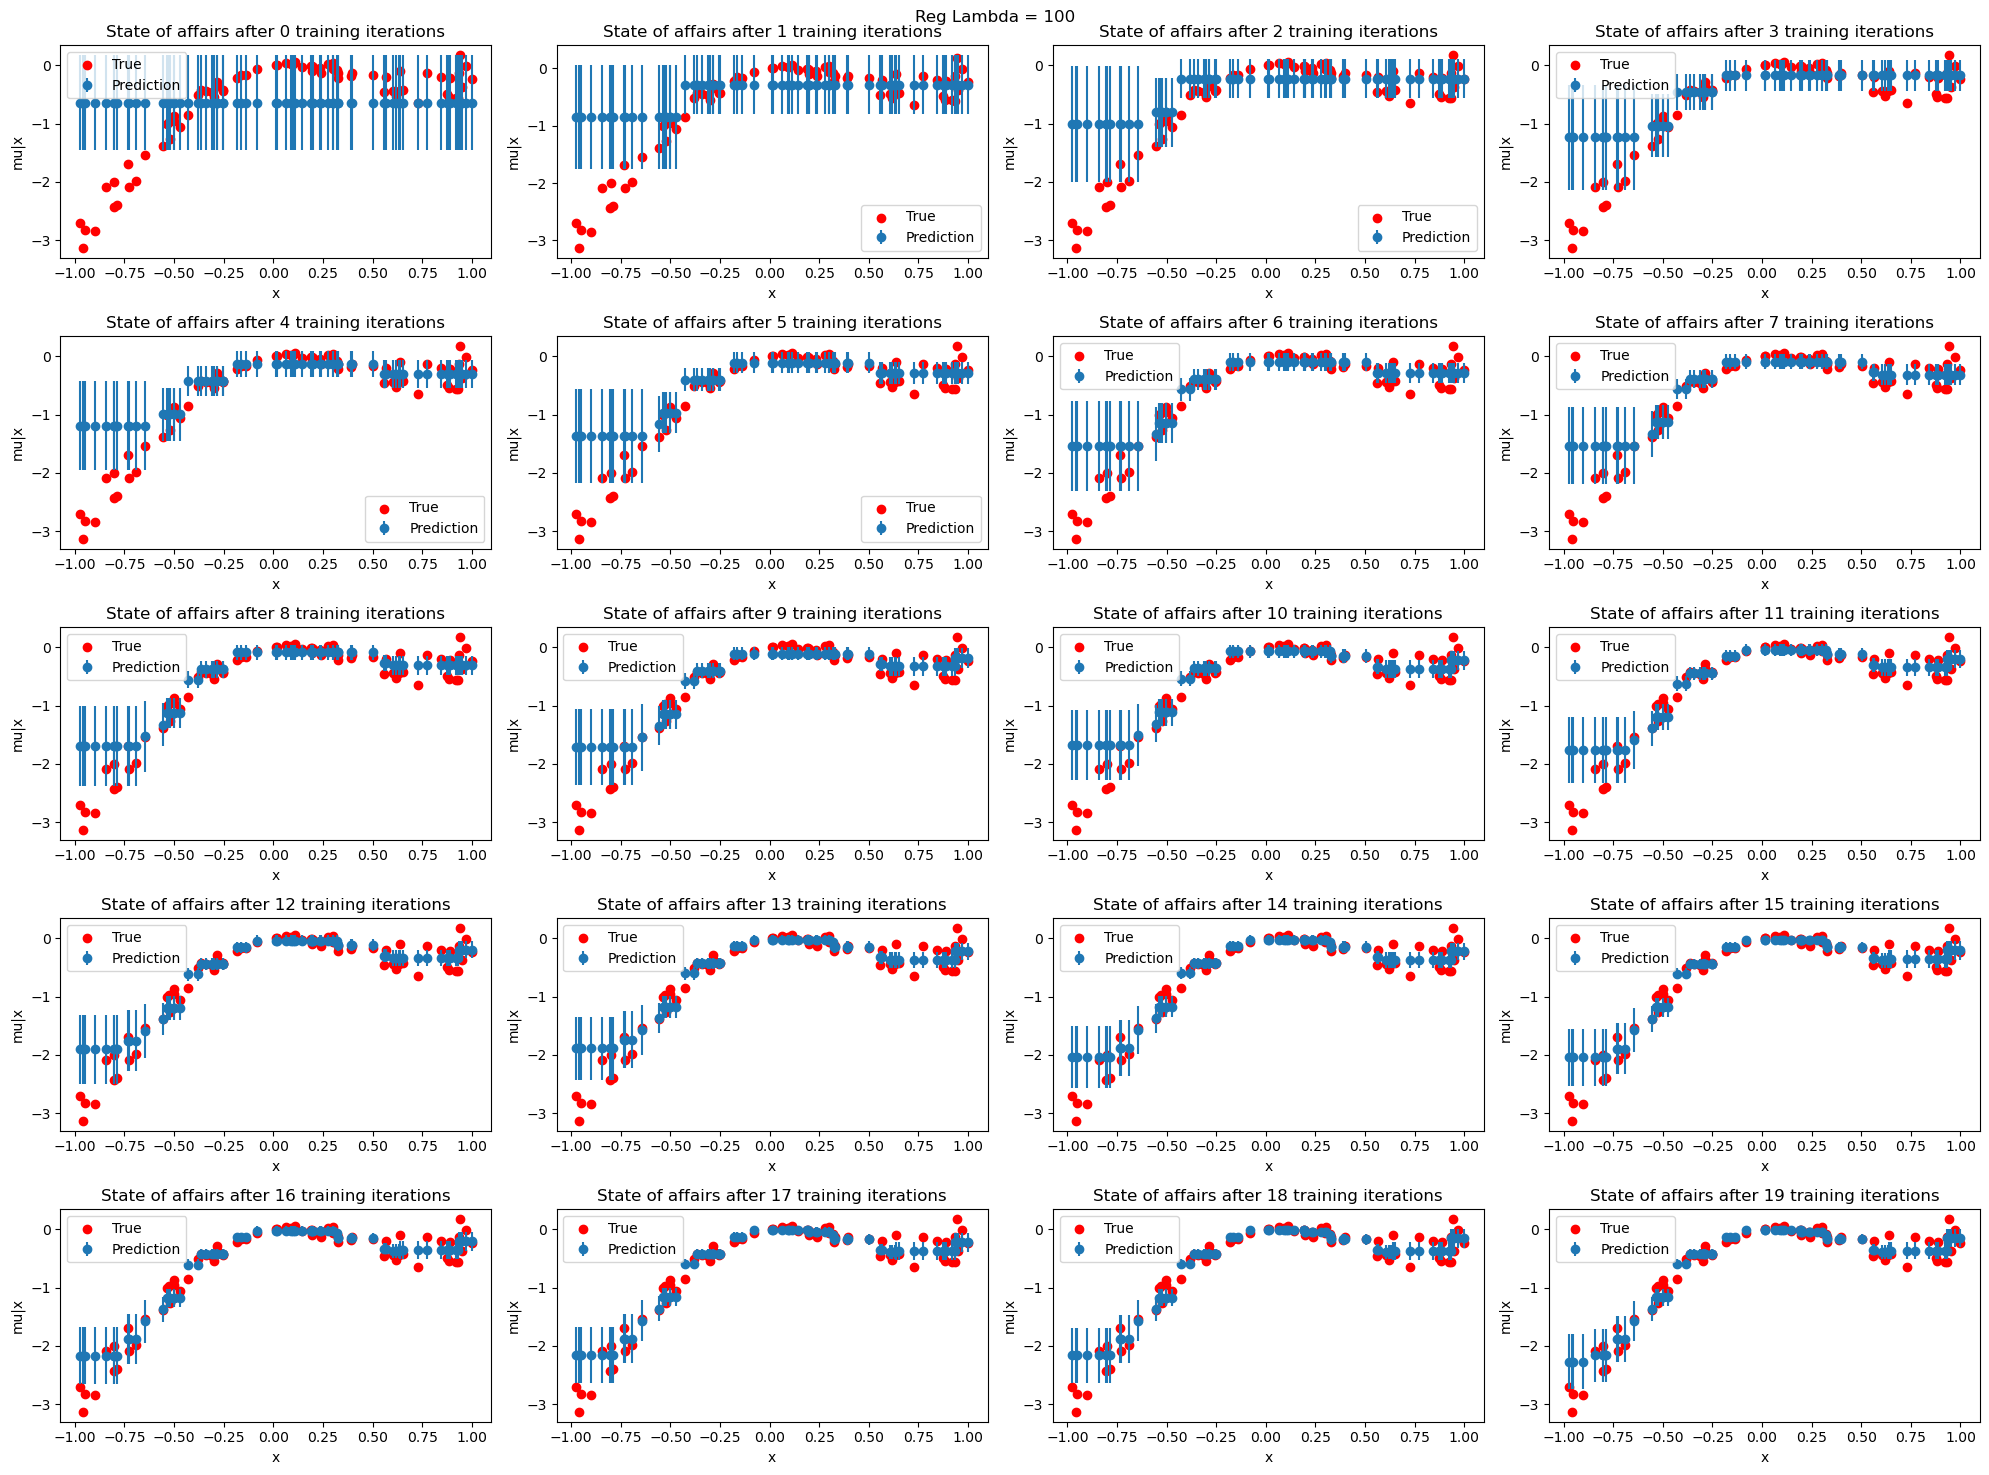

In [79]:
current_mus = np.mean(y_train)*np.ones(len(y_train), dtype=float)
current_gammas =  np.log(np.std(y_train))*np.ones(len(y_train), dtype=float)

# current_mus = 0.5*np.ones(len(y_train), dtype=float)
# current_gammas =  0.5*np.ones(len(y_train), dtype=float)

learning_rate = 1.0

sorter = np.argsort(x_train.flatten())

REG_LAMBDA = 100

plt.figure(figsize=(20,15))
plt.suptitle("Reg Lambda = %d"%REG_LAMBDA)
for iterations in range(20):
    
#     if iterations%10==0:
#         plt.subplot(5,4,(iterations//10)+1)
    plt.subplot(5,4,iterations+1)
    plt.title("State of affairs after %d training iterations"%iterations)
    plt.errorbar(x_train.flatten()[sorter], current_mus, yerr=np.exp(current_gammas), fmt="o", label='Prediction')
    plt.scatter(x_train.flatten()[sorter], y_train[sorter], label='True', c='r')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("mu|x")
    plt.tight_layout()
    
    current_mus, current_gammas = find_best_split(y_train[sorter], current_mus, current_gammas, REG_LAMBDA)
    
plt.show()
    
    